In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt

In [3]:
data = '/content/drive/MyDrive/trajectories_imu/df_RGC.pkl'
with open(data, 'rb') as file:
    data = pickle.load(file)

label = '/content/drive/MyDrive/trajectories_imu/labels_RGC.pkl'
with open(label, 'rb') as file:
    labels = pickle.load(file)

labels = labels.astype(float)/100
labels = labels.values

In [4]:
data = np.reshape(data,(data.shape[0], data.shape[2],3))
print(data.shape,len(labels))

(102, 1127, 3) 102


In [5]:
def build_model(lr=0.001, units_lstm=64, units_lstm_2=32, units_dense=16):
    model = tf.keras.Sequential()

    # Capa LSTM 1
    model.add(layers.LSTM(units_lstm, return_sequences=True, input_shape=(data.shape[1], data.shape[2])))

    # Capa LSTM 2
    model.add(layers.LSTM(units_lstm_2, return_sequences=False))

    # Capa totalment connectada
    model.add(layers.Dense(units_dense, activation='relu')) # ReLU per evitar la saturació de gradients

    # Capa final totalment connectada amb funció d'activació sigmoide
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

def create_dataloader(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    return dataset

(81,) (21,)


# HYPERPARAMETER TUNNING

In [7]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],  # Learning Rate
    'units_lstm': [32, 64, 128],  # Unitats en la primera capa GRU
    'units_lstm_2': [16, 32, 64],  # Unitats en la segona capa GRU,
    'units_dense': [8, 16, 32]
}

keras_model = KerasRegressor(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament

#cross-validation
grid_search = RandomizedSearchCV (keras_model, param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

<ipython-input-7-684878242045>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasRegressor(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament


In [8]:
#evaluacio del model amb els millor hiperparàmetres
best_model = grid_result.best_estimator_.model
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print("\nLoss al conjunt de prova:", test_loss)
print("Error abolut mitjà al conjunt de prova:", test_mae)

1/1 [==============================] - 1s 1s/step - loss: 0.2038 - mae: 0.3881

Loss al conjunt de prova: 0.20380274951457977
Error abolut mitjà al conjunt de prova: 0.38808733224868774


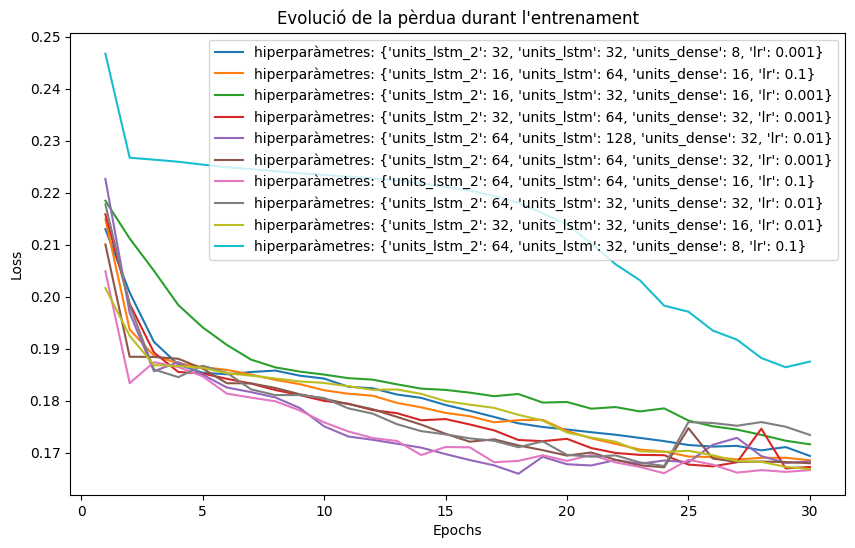

In [9]:
# Obtenir l'historial d'entrenament per a cada combinació d'hiperparàmetres
loss_history = []
for params, cv_results in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
    model = build_model(**params)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=0)
    loss_history.append(history.history['loss'])

plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history):
    plt.plot(range(1, len(loss)+1), loss, label=f"hiperparàmetres: {grid_result.cv_results_['params'][i]}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la pèrdua durant l\'entrenament')
plt.legend()
plt.show()

In [10]:
print("Millors hiperparàmetres:")
print(grid_result.best_params_)

print("\nMillor score:")
print(grid_result.best_score_)

Millors hiperparàmetres:
{'units_lstm_2': 64, 'units_lstm': 32, 'units_dense': 32, 'lr': 0.01}

Millor score:
-0.17504043380419412


Epoch 1/20
6/6 [==============================] - 11s 897ms/step - loss: 0.2097 - mae: 0.4213
Epoch 2/20
6/6 [==============================] - 6s 1s/step - loss: 0.1794 - mae: 0.3688
Epoch 3/20
6/6 [==============================] - 5s 873ms/step - loss: 0.1874 - mae: 0.3969
Epoch 4/20
6/6 [==============================] - 7s 1s/step - loss: 0.1952 - mae: 0.4233
Epoch 5/20
6/6 [==============================] - 5s 909ms/step - loss: 0.1765 - mae: 0.3849
Epoch 6/20
6/6 [==============================] - 7s 1s/step - loss: 0.1766 - mae: 0.3523
Epoch 7/20
6/6 [==============================] - 5s 870ms/step - loss: 0.1771 - mae: 0.3426
Epoch 8/20
6/6 [==============================] - 5s 885ms/step - loss: 0.1742 - mae: 0.3390
Epoch 9/20
6/6 [==============================] - 7s 1s/step - loss: 0.1762 - mae: 0.3594
Epoch 10/20
6/6 [==============================] - 6s 902ms/step - loss: 0.1891 - mae: 0.3386
Epoch 11/20
6/6 [==============================] - 5s 872ms/step - loss: 0.1771 

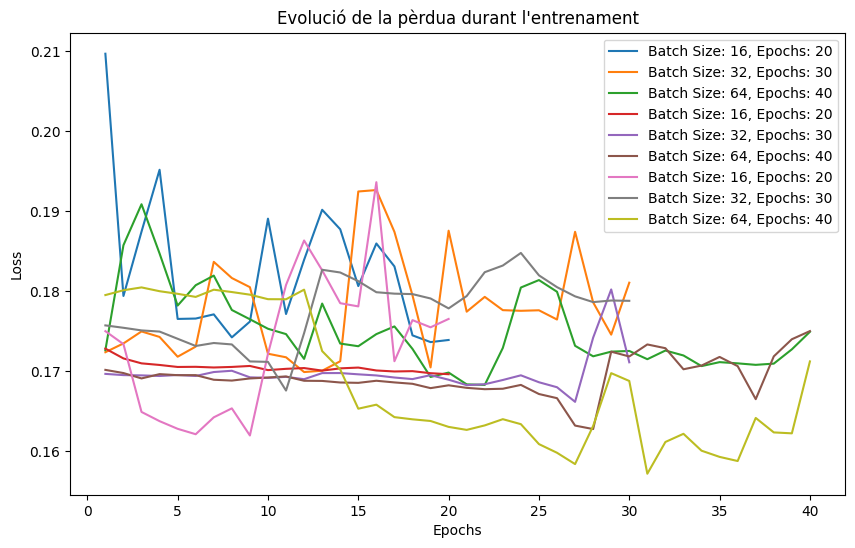

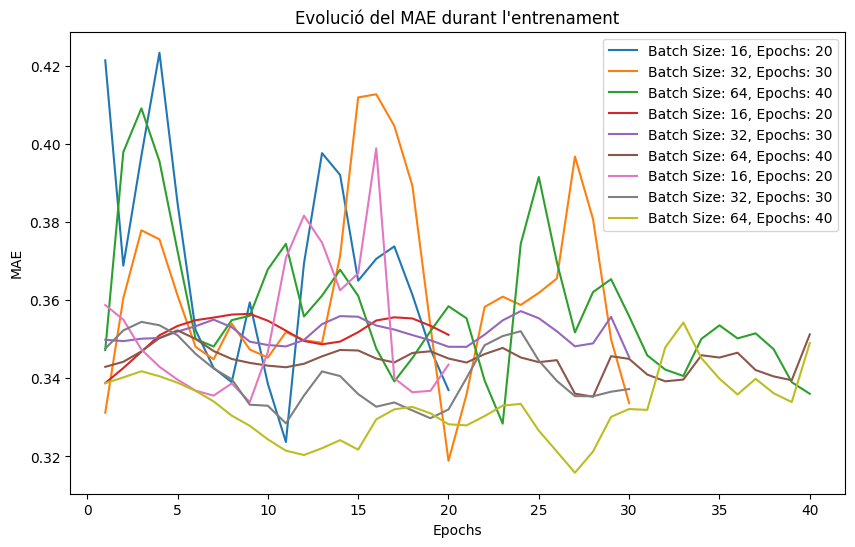

In [11]:
# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)

#Diferents valors a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

loss_values = []
mae_values = []

for batch_size in batch_sizes:
    for epochs in epochs_values:
        train_dataset = create_dataloader(X_train, y_train, batch_size)
        history = model.fit(train_dataset, epochs=epochs, verbose=1)

        loss_values.append(history.history['loss'])
        mae_values.append(history.history['mae'])

#Graficar l'evolució de les proves (loss)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(loss_values[i])+1), loss_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la pèrdua durant l\'entrenament')
plt.legend()
plt.show()

#Graficar l'evolució de les proves (mae)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(mae_values[i])+1), mae_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Evolució del MAE durant l\'entrenament')
plt.legend()
plt.show()


In [13]:
# Número de Batchs i Epochs a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

best_mae = float('inf')
best_batch_size = None
best_epochs = None

# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
# Cerca d'hiperparàmetres
for batch_size in batch_sizes:
    for epochs in epochs_values:
        model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

        _, test_mae = model.evaluate(X_test, y_test, verbose=0)

        if test_mae < best_mae:
            best_mae = test_mae
            best_batch_size = batch_size
            best_epochs = epochs

print("Millor combinació d'hiperparàmetres:")
print("Batch size:", best_batch_size)
print("Epochs:", best_epochs)
print("MAE en el conjunt de prova:", best_mae)

Millor combinació d'hiperparàmetres:
Batch size: 64
Epochs: 20
MAE en el conjunt de prova: 0.3892708420753479


# Model final

In [15]:
# Emmagatzemar els hiperparàmetres
units_lstm_2, units_lstm, units_dense, lr = grid_result.best_params_['units_lstm_2'], grid_result.best_params_['units_lstm'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
batch_size = best_batch_size

#creació i compilació model
final_model = build_model(lr=lr, units_lstm=units_lstm, units_lstm_2=units_lstm_2, units_dense=units_dense)

# Creació del DataLoader
train_dataset = create_dataloader(X_train, y_train, batch_size)

#entrenament del model amb els hyperparametres trobats
final_model.fit(train_dataset, epochs=best_epochs, verbose=0)

#Evaluació amb el conjunt test
test_dataset = create_dataloader(X_test, y_test, batch_size)
test_loss, test_mae = final_model.evaluate(test_dataset, verbose=0)
print(f"Loss al conjunt de prova: {test_loss}")
print(f"MAE al conjunt de prova: {test_mae}")

Loss al conjunt de prova: 0.21789073944091797
MAE al conjunt de prova: 0.4138314425945282


In [16]:
y_pred = final_model.predict(X_test)
for i in range(len(y_test)):
  print(y_test[i],"                   ",y_pred[i])

1/1 [==============================] - 1s 1s/step
0.0                     [0.5473713]
0.8569766235351562                     [0.6927975]
1.0                     [0.58259284]
0.9870536804199219                     [0.7484456]
0.6351990127563476                     [0.70936555]
1.0                     [0.50573206]
0.0                     [0.6714604]
1.0                     [0.58688796]
0.9744159698486328                     [0.5436399]
0.0                     [0.6129056]
1.0                     [0.54218787]
0.0                     [0.5473713]
0.6449063873291015                     [0.64280367]
1.0                     [0.7232954]
0.8045121002197265                     [0.62440675]
0.9029817199707031                     [0.65220857]
1.0                     [0.71260804]
0.0                     [0.718097]
0.0                     [0.7845328]
0.0                     [0.7365892]
1.0                     [0.6152738]
